<a href="https://colab.research.google.com/github/praveenkumarchandaliya/STTP_Program/blob/XAI/GradCAM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import urllib.request
from PIL import Image
import json
from functools import partial
from google.colab.patches import cv2_imshow
# from IPython.display import Image
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
target_url ="https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
classes = []
for line in urllib.request.urlopen(target_url):
  classes.append(line.decode('utf-8'))

def load_image(img_path, size=None):
    img = Image.open(img_path)
    img = img.convert(mode='RGB')

    if size is not None:
        img = img.resize(size)
    return img

def preprocess_image(pil_img):
    tensor = transforms.ToTensor()(pil_img)
    tensor = torch.unsqueeze(tensor, dim=0)  # (B, C, H, W)

    return tensor

def batch_load(path, size=[224,224], viz=True):
  imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
  imagenet_std = torch.tensor([0.229, 0.224, 0.225])
  # input_size = [224, 224]

  transform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(imagenet_mean, imagenet_std),
  ])

  # img = Image.open("dog1.jpg")
  # img = Image.open('./data/Elephant/1.png')
  img = load_image(path, size=size)
  if viz:
    display(img)
  img_t = transform(img)
  batch_t = torch.unsqueeze(img_t, 0) # shape : [1,3,224,224]
  img
  return batch_t


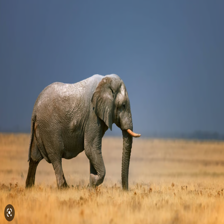

In [ ]:
test_image = batch_load('/content/drive/MyDrive/STTP/1.png')

In [ ]:
# Locate the target FM
vgg_19 = vgg19(pretrained=True)
print(vgg_19)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 79.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Model Modification

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)

        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook at the feature map that we are interested in.
        # register hook obtain the gradient
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
# initialize the VGG model & set the evaluation mode
vgg = VGG()
vgg.eval()

# define Infer function w/ top 3 classes
def infer(model, input): #vgg  pred
  # get the most likely prediction of the model
  pred = model(input) # .argmax(dim=1)
  # print(pred.shape)
  #print the top 3 classes predicted by the model
  topk=3
  _, indices = torch.sort(pred, descending=True)
  percentage = torch.nn.functional.softmax(pred, dim=1)[0] * 100
  print([(classes[idx], idx.data, percentage[idx].item()) for idx in indices[0][:topk]])
  return pred

In [ ]:
# forward
pred = infer(vgg, test_image)

[('African elephant\n', tensor(386), 55.281333923339844), ('tusker\n', tensor(101), 38.80613327026367), ('Indian elephant\n', tensor(385), 5.912374496459961)]


# Obtain Grad-CAM：

In [ ]:
def get_cam(pred, input):
  # 1. get the gradient of the output with respect to the parameters of the model
  pred[:, 386].backward()

  # 2. get the activations of the last convolutional layer
  activations = vgg.get_activations(input).detach()

  # 3. pull the gradients out of the model
  gradients = vgg.get_activations_gradient()

  # 4. pool the gradients across the channels
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  # 5. weight the channels by corresponding gradients
  for i in range(512):
      activations[:, i, :, :] *= pooled_gradients[i]
  #   average the channels of the activations
  heatmap = torch.mean(activations, dim=1).squeeze()

  # 6. relu on top of the heatmap
  #   expression (2) in https://arxiv.org/pdf/1610.02391.pdf
  heatmap = np.maximum(heatmap, 0)

  # 7. normalize the heatmap
  heatmap /= torch.max(heatmap)

  # draw the heatmap
  plt.matshow(heatmap.squeeze())
  return heatmap


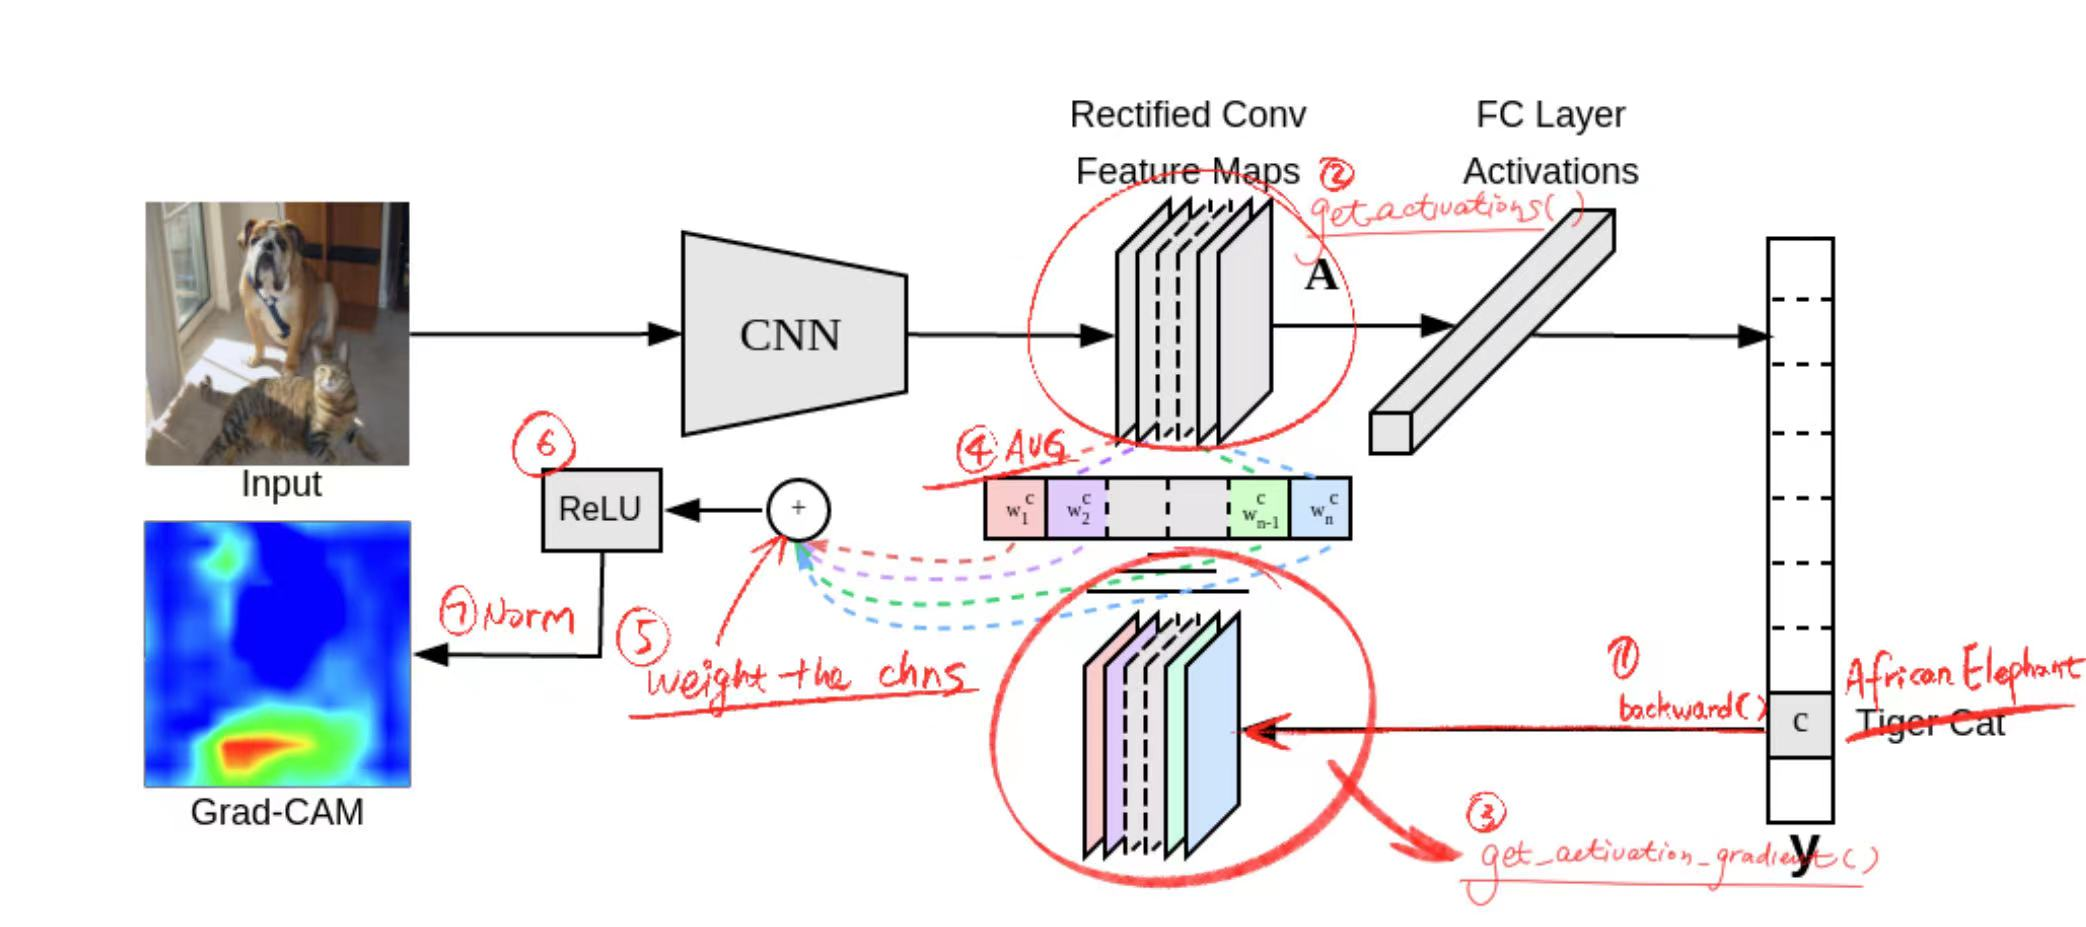

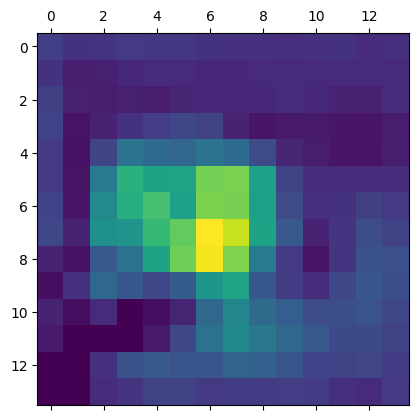

In [ ]:
heatmap = get_cam(pred, test_image)

In [ ]:
def overlayCAM(heatmap, origin_img_path):
  img = cv2.imread(origin_img_path)
  heatmap = heatmap.numpy()
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2.imwrite('./map.jpg', superimposed_img)
  cv2_imshow(superimposed_img)

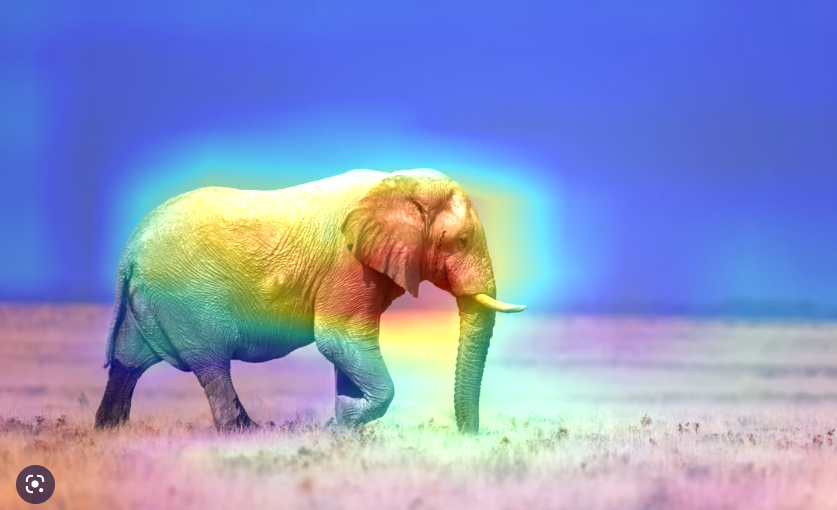

In [ ]:
overlayCAM(heatmap, '/content/drive/MyDrive/STTP/1.png')